In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from neuralprophet import NeuralProphet
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

In [2]:
# x is how much hours which are used to train model, and from x to x+7*24 hours will be forecasted
x = 29880    # x = 29976 (style changing period) or 30000-5*24 = 29880 (peaks water demand period)

In [3]:
df = pd.read_csv('E:\sciebo\Data\pre_processed_Raw_data_demand_KK_freq_60.csv')
df.iloc[:,0] = pd.to_datetime(df.iloc[:,0], infer_datetime_format=True) 
df.iloc[:,0] = df.iloc[:,0].dt.tz_localize(None) 
df.rename(columns = {'datetime_utc':'ds', 'adjusted':'y'}, inplace = True)
df

,ds,y
0,2018-01-15 08:00:00,59.759240
1,2018-01-15 09:00:00,59.226733
2,2018-01-15 10:00:00,84.631849
3,2018-01-15 11:00:00,107.245748
4,2018-01-15 12:00:00,96.690556
...,...,...
30384,2021-07-04 08:00:00,86.438042
30385,2021-07-04 09:00:00,92.873500
30386,2021-07-04 10:00:00,96.202250
30387,2021-07-04 11:00:00,105.203000


In [4]:
df_t = df.loc[0:x]
df_t

,ds,y
0,2018-01-15 08:00:00,59.759240
1,2018-01-15 09:00:00,59.226733
2,2018-01-15 10:00:00,84.631849
3,2018-01-15 11:00:00,107.245748
4,2018-01-15 12:00:00,96.690556
...,...,...
29876,2021-06-13 04:00:00,25.803335
29877,2021-06-13 05:00:00,32.904266
29878,2021-06-13 06:00:00,50.624876
29879,2021-06-13 07:00:00,80.502306


In [5]:
df_f=df.loc[0:x+268]
df_f

,ds,y
0,2018-01-15 08:00:00,59.759240
1,2018-01-15 09:00:00,59.226733
2,2018-01-15 10:00:00,84.631849
3,2018-01-15 11:00:00,107.245748
4,2018-01-15 12:00:00,96.690556
...,...,...
30144,2021-06-24 08:00:00,98.855625
30145,2021-06-24 09:00:00,96.984295
30146,2021-06-24 10:00:00,104.043444
30147,2021-06-24 11:00:00,95.220694


In [6]:
df_t = df.loc[0:x]


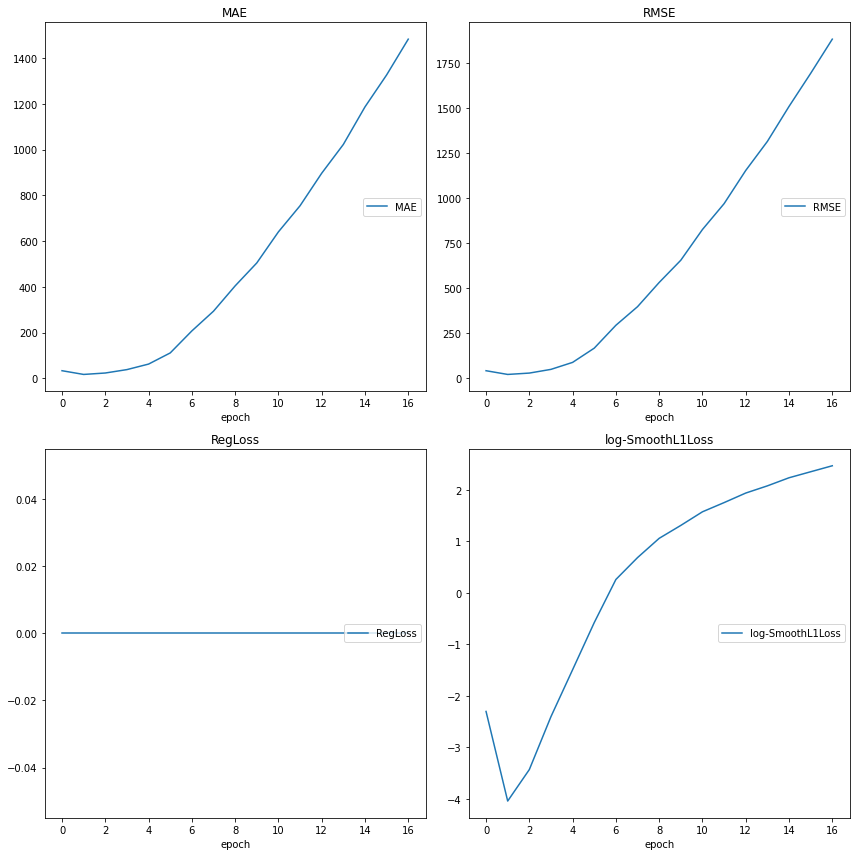

MAE
	MAE              	 (min:   16.855, max: 1482.443, cur: 1482.443)
RMSE
	RMSE             	 (min:   22.536, max: 1883.820, cur: 1883.820)
RegLoss
	RegLoss          	 (min:    0.000, max:    0.000, cur:    0.000)
log-SmoothL1Loss
	log-SmoothL1Loss 	 (min:   -4.044, max:    2.465, cur:    2.465)


In [ ]:
m = NeuralProphet( 
                 n_forecasts=24*7,
                 n_lags=24*14, 
                 d_hidden = 2,
                 ar_reg=0.01,
                 #ar_sparsity=0.1,
                 #batch_size = 365*24,
                 learning_rate=1,
#                changepoint_prior_scale = 0.003,
#                seasonality_prior_scale = 0.01,
                 changepoints_range=0.95,
                 n_changepoints=3,
                 daily_seasonality=7 ,yearly_seasonality = 6,weekly_seasonality = 2
#                mcmc_samples=100
                 )
m.add_country_holidays(country_name="Germany")
future = m.make_future_dataframe(
                                    df_t, periods=170,n_historic_predictions=True
                                 )
future = future.loc[0:x+168]
metrics = m.fit(df_t, progress="plot-all")

In [ ]:
forecast = m.predict(future)
fig = m.plot_component(forecast)
m.plot(forecast)  

In [ ]:
import plotly.graph_objs as go
from plotly.offline import init_notebook_mode, iplot
init_notebook_mode(connected=True)
df_3 = df.loc[x-24*3:x+168]
forecast_3 = forecast.loc[x:x+368]
trace1 = go.Scatter(
                    x = df_3.ds,                          
                    y = df_3.y,                    
                    mode = "lines+markers",                
                    name = "real waterdemand",             
                    marker = dict(color = 'rgba(16, 112, 2, 0.8)'),   
                    )
trace2 = go.Scatter(
                    x = forecast_3.ds,
                    y = forecast_3.yhat7,
                    mode = "lines+markers",                
                    name = "forecast waterdemand 7hours",
                    marker = dict(color = 'rgba(80, 26, 80, 0.8)'),
                    )

data = [trace1, trace2]
layout = dict(
              title = ' forecast and real water demand',            
              xaxis= dict(title= 'time',ticklen= 50,zeroline= True)
              ) 
fig = dict(data = data, layout = layout)
iplot(fig)

In [ ]:
forecast1 = forecast[x:x+168]
forecast1=forecast1.filter(regex= 'yhat',axis = 1)
forecast1 

In [ ]:
for index, row in forecast1.iteritems():
    print(index) # columns names
def func(x):
    if x.first_valid_index() is None:
        return None
    else:
        return x[x.first_valid_index()]


In [ ]:
forecast_text = forecast1.apply(func, axis=1)
forecast_text = pd.DataFrame ( forecast_text, columns = ['y_hat_first']) 
forecast_text

In [ ]:
df_3 = df.loc[x  :x +168]
data_forecast3 = future.loc[x - 5*24 :x +168]
forecast_3 = forecast.loc[x:x+168]
trace1 = go.Scatter(
                    x = df_3.ds,                          
                    y = df_3.y,                    
                    mode = "lines+markers",                
                    name = "real waterdemand",             
                    marker = dict(color = 'rgba(16, 112, 2, 0.8)'),   
                    )
trace2 = go.Scatter(
                    x = forecast_3.ds,
                    y = forecast_text.y_hat_first,
                    mode = "lines+markers",               
                    name = "forecast waterdemand first step",
                    marker = dict(color = 'rgba(80, 26, 80, 0.8)'),    
                    )



data = [trace1, trace2]
layout = dict(
              title = 'Neural prophet forecast and real water demand without weather parameters',            
              xaxis= dict(title= 'time',ticklen= 50,zeroline= True)
              ) 
fig = dict(data = data, layout = layout)
iplot(fig)

In [ ]:
y_true = df_f.loc[x:x+72,'y']
y_yhat = forecast_text.loc[x:x+72,'y_hat_first']

In [ ]:
mean_absolute_error(y_true, y_yhat)      #     3    days

In [ ]:
mean_squared_error(y_true, y_yhat) 

In [ ]:
y_true = df_f.loc[x:x+7*24-1,'y']
y_yhat = forecast_text.loc[x:x+7*24]

In [ ]:
mean_absolute_error(y_true, y_yhat)               #  7  days

In [ ]:
mean_squared_error(y_true, y_yhat)            